In [3]:
from IPython.html import widgets
%matplotlib inline

import numpy as np
from base.classifiers import OnevsallContinuous
import pandas as pd
from scipy import stats
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpld3.disable_notebook()
import scipy
import glob
from base.statistics import dcor
from base import tools

from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Load up data

In [52]:
clf = OnevsallContinuous.load("../results/aal_GNB_t0.05_cog_topics_60/classifier.pkl") 

In [1]:
rs_fmri = pd.read_csv("../masks/Andy/mean_matrix_264.csv", header=None)

NameError: name 'pd' is not defined

In [2]:
rs_fmri = np.array(rs_fmri)

NameError: name 'np' is not defined

In [19]:
pd.DataFrame(clf.feature_importances.data).to_csv("../data/rscomp/regions_by_features.csv")

In [20]:
pd.Series(clf.scores).to_csv("../data/rscomp/classification_performance.csv")

Calculate correlations between regions based on functional labels

In [21]:
clf.class_score.shape

(264,)

In [22]:
fi_coef = np.corrcoef(clf.feature_importances)

In [23]:
fi_coef_d = pd.DataFrame(fi_coef)

Correlation of activation in Neurosynth of regions

In [24]:
from neurosynth.analysis.reduce import average_within_regions
import itertools
a_coef = np.corrcoef(average_within_regions(dataset, '../masks/Andy/pet_MNI_V1.nii.gz' ))

### Results

In [25]:
a_coef = tools.mask_diagonal(np.ma.masked_array(a_coef))

In [26]:
rs = np.random.RandomState(33)
d = rs.normal(size=(100, 30))

In [27]:
a_coef.min()

-0.022652994743817621

In [28]:
plt.subplots(figsize=(90, 90))
# sns.heatmap(fi_coef, square=True, robust=True)
plt.savefig('../../rs_metaanalysis/meta_feature_heatmap.pdf', bbox_inches='tight', cbar=False)

KeyboardInterrupt: 

In [ ]:
?sns.heatmap

In [29]:
meta_vs_rs_long = pd.melt(meta_vs_rs, value_vars=['Cocativation', 'Cognitive Functions'], value_name = 'Meta-analytic distance', var_name='Measure', id_vars='Resting-state distance')

ERROR! Session/line number was not unique in database. History logging moved to new session 181


NameError: name 'meta_vs_rs' is not defined

In [30]:
fi_vs_rs = pd.DataFrame(np.vstack([np.triu(rs_fmri).flatten(), np.triu(fi_coef).flatten()]).T, columns=['Resting-state distance', 'Meta-analytic feature distance'])
fi_vs_rs['Measure'] = "Cognitive Functions"

In [ ]:
coact_vs_rs = pd.DataFrame(np.vstack([np.triu(rs_fmri).flatten(), np.triu(a_coef).flatten()]).T, columns=['Resting-state distance', 'Meta-analytic cocativation distance'])
coact_vs_rs['Measure'] = "Coactivation"

In [ ]:
meta_vs_rs = pd.concat([fi_vs_rs, coact_vs_rs])

In [ ]:
sns.set_context(context="poster")
sns.lmplot('Resting-state distance', 'Meta-analytic distance', meta_vs_rs, col='Measure', size=8)

How correlated is Neurosynth activation with resting state coactivation?

In [ ]:
lm1 = sns.regplot('Meta-analytic feature distance', 'Resting-state distance', fi_vs_rs)
lm1.axes.set_xlim(-0.6,1)
lm1.axes.set_ylim(-0.4,0.8)
plt.savefig('../../rs_metaanalysis/meta_feat_rs_corr.pdf')

In [ ]:
lm2 = sns.regplot('Meta-analytic cocativation distance', 'Resting-state distance', coact_vs_rs)
lm2.axes.set_xlim(-0.3,1)
lm2.axes.set_ylim(-0.4,0.8)
plt.savefig('../../rs_metaanalysis/coact_rs_corr.pdf')

In [ ]:
lm1.axes

Very correlated. This has been shown before though

How correlated with region's functional labels from Neurosynth with resting state coactivation?

In [ ]:
stats.pearsonr(a_coef.flatten(), fi_coef.flatten())

In [ ]:
stats.pearsonr(fi_coef.flatten(), rs_fmri.flatten())

In [ ]:
stats.pearsonr(a_coef.flatten(), rs_fmri.flatten())

In [ ]:
51.4, 68.6

Correlated fairly highly. Also interesting is that the sign of the correlations is almost the same. Most regions that are negatively correalted are so in both, and vice versa.

This correlation is actually pretty healthy given that with these sets of masks, the classification accuracy was fairly low:

In [ ]:
sns.distplot(clf.class_score, bins=20)

In [ ]:
clf.class_score.mean()
# Pretty low performance

## Functional analysis

In [77]:
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/top_words_" + "60" + ".csv")
word_keys['top_2'] = word_keys.top_words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

In [78]:
o_fi = pd.DataFrame(clf.feature_importances)
# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

word_keys = pd.merge(pd.DataFrame(np.array([range(0, clf.feature_importances.shape[1]), clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
word_keys.topic_order = word_keys.topic_order.astype('int')

o_fis_melt= pd.merge(o_fis_melt, word_keys)

In [79]:
zscore = lambda x: (x - x.mean()) / x.std()
o_fis_melt['importance_z'] = o_fis_melt.groupby('region')['importance'].apply(zscore)

In [33]:
plt.subplots(figsize=(250, 20))
sns.heatmap(pd.pivot_table(o_fis_melt, values='importance_z', index=['top_2'], columns=['region']), square=True)

KeyboardInterrupt: 

In [ ]:
sel_topics = o_fis_melt[o_fis_melt.groupby('region').rank(ascending=False).importance < 2]
top_n = o_fis_melt[np.in1d(o_fis_melt.topic_name, sel_topics.topic_name) ]

In [ ]:
pd.pivot_table(top_n, values='importance', index=['top_2'], columns=['region']).shape

In [ ]:
plt.subplots(figsize=(250, 20))

sns.heatmap(pd.pivot_table(top_n, values='importance_z', index=['top_2'], columns=['region']), square=True)

In [ ]:
sns.clustermap(pd.pivot_table(o_fis_melt, values='importance_z', index=['top_2'], columns=['region']), robust=True, linewidths=0.01, col_cluster=False, figsize = (6, 8))
plt.savefig('../../rs_metaanalysis/meta_heatmap_small.pdf')

In [ ]:
?sns.clustermap

### Graph theory measures

In [53]:
import csv
degrees = [open(file, 'rb') for file in glob.glob('../data/aal/d*')]

In [54]:
degrees

[<open file '../data/aal/degree_15.csv', mode 'rb' at 0x135f16db0>,
 <open file '../data/aal/degree_25.csv', mode 'rb' at 0x135f16ed0>,
 <open file '../data/aal/degree_40.csv', mode 'rb' at 0x135f16f60>]

In [55]:
with open('../data/aal/degree_15.csv', 'rb') as file:
    reader = csv.reader(file)
    degrees = list(reader)

In [56]:
degrees[0] = [float(s) for s in degrees[0]]

In [57]:
for input in ['../data/aal/degree_25.csv', '../data/aal/degree_40.csv', '../data/aal/participation_15.csv', '../data/aal/participation_25.csv', '../data/aal/participation_40.csv']:
    with open(input, 'rb') as file:
        res = []
        reader = csv.reader(file)
        for row in reader:
            res.append(float(row[0]))
        degrees.append(res)

In [58]:
degrees = [range(1, len(degrees[0]) + 1)] + degrees

In [59]:
deg_part = pd.DataFrame(np.array(degrees).T, columns = ['region', 'd_15', 'd_25', 'd_40', 'p_15', 'p_25', 'p_40'])

In [60]:
deg_part.shape

(116, 7)

In [61]:
deg_part['score'] = clf.class_score
deg_part['fi_mean'] = clf.feature_importances.mean(axis=1)
deg_part['fi_mean_abs'] = np.abs(clf.feature_importances).mean(axis=1)
deg_part['fi_var'] = clf.feature_importances.var(axis=1)

In [62]:
np.set_printoptions(threshold='nan')
np.corrcoef(deg_part.T[1:])

array([[ 1.        ,  0.67345497,  0.3832869 , -0.05173486, -0.09226927,
        -0.12051728,  0.0010971 , -0.05163485, -0.0099052 ,  0.02785183],
       [ 0.67345497,  1.        ,  0.78904194,  0.29034759,  0.31431014,
         0.29784497, -0.04459853, -0.3417324 , -0.02488063,  0.05734489],
       [ 0.3832869 ,  0.78904194,  1.        ,  0.39176382,  0.45552679,
         0.53525179, -0.06425915, -0.54657102,  0.07937756,  0.07342047],
       [-0.05173486,  0.29034759,  0.39176382,  1.        ,  0.95511411,
         0.90696857,  0.31128251, -0.13035092,  0.31010258,  0.10874921],
       [-0.09226927,  0.31431014,  0.45552679,  0.95511411,  1.        ,
         0.97232778,  0.23094981, -0.21068418,  0.27763873,  0.07741262],
       [-0.12051728,  0.29784497,  0.53525179,  0.90696857,  0.97232778,
         1.        ,  0.14977373, -0.30372116,  0.26623379,  0.04123242],
       [ 0.0010971 , -0.04459853, -0.06425915,  0.31128251,  0.23094981,
         0.14977373,  1.        ,  0.4109534 

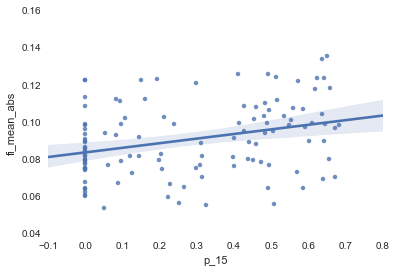

In [63]:
sns.regplot('p_15', 'fi_mean_abs',data=deg_part )

In [64]:
deg_part.apply(lambda x: stats.spearmanr(deg_part.fi_mean_abs, x))

region          (-0.210925306577, 0.0230402773862)
d_15           (-0.00697392181009, 0.940772550648)
d_25           (0.000588924103688, 0.994993933469)
d_40              (0.126856540372, 0.174787756931)
p_15           (0.306304644295, 0.000825703966963)
p_25            (0.257564825755, 0.00525012866685)
p_40             (0.26263022335, 0.00439732970677)
score          (0.795533002729, 1.45974851074e-26)
fi_mean          (0.0934840272172, 0.318212571125)
fi_mean_abs                             (1.0, 0.0)
fi_var         (0.877691923269, 3.23306196025e-38)
dtype: object

In [65]:
deg_part.apply(lambda x: stats.spearmanr(deg_part.score, x))

region         (-0.413316418714, 4.00240523078e-06)
d_15              (0.0299185098648, 0.749867613529)
d_25             (0.00250581432353, 0.978702036166)
d_40            (-0.00684328295594, 0.941880070736)
p_15            (0.324250345686, 0.000383912969324)
p_25              (0.225213465272, 0.0150710346234)
p_40              (0.167916041979, 0.0715861312465)
score                                    (1.0, 0.0)
fi_mean         (0.353461730673, 9.93879627703e-05)
fi_mean_abs     (0.795533002729, 1.45974851074e-26)
fi_var          (0.744958290086, 9.03726718792e-22)
dtype: object

In [66]:
deg_part.apply(lambda x: stats.spearmanr(deg_part.fi_var, x))

region           (-0.077807250221, 0.406429145945)
d_15             (0.0330972311319, 0.724310121806)
d_25             (0.0833308360832, 0.373826282796)
d_40              (0.133784450773, 0.152217404495)
p_15             (0.172665698471, 0.0638144981637)
p_25                (0.1298515615, 0.164745206029)
p_40              (0.111913274132, 0.231676727609)
score          (0.744958290086, 9.03726718792e-22)
fi_mean          (0.0933533233383, 0.318892636863)
fi_mean_abs    (0.877691923269, 3.23306196025e-38)
fi_var                                  (1.0, 0.0)
dtype: object

## Multivariateness measure

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from base import mv

In [69]:
mv_results_all = mv.calc_mv_classifier(clf, roc_auc_score, processes=8, method='combinatorial')


[##########] 100%


In [80]:
import base.statistics as my_stats
o_fis_melt['imp_min'] = o_fis_melt.importance + o_fis_melt.importance.min()*-1 
sdi = pd.DataFrame(o_fis_melt.groupby('region').apply(lambda x: my_stats.shannons(x['imp_min'])), columns=['sdi']).reset_index()

In [86]:
sdi

,region,sdi
0,1,3.421574
1,2,3.400136
2,3,3.415534
3,4,3.442741
4,5,3.411264
5,6,3.413435
6,7,3.412400
7,8,3.432835
8,9,3.456199
9,10,3.460798


In [102]:
mv_1 = mv_results_all[mv_results_all.num_features == 1][['region', 'score']].rename(columns={'score':'score_1'})
mv_max = mv_results_all.groupby('region').max().reset_index()[['region', 'score']].rename(columns={'score':'score_max'})
mv_20 = mv_results_all[mv_results_all.num_features == 20][['region', 'score']].rename(columns={'score':'score_20'})
mv_summaries = pd.merge(pd.merge(mv_1, mv_max), mv_20)
mv_summaries['score_diff'] = mv_summaries['score_max'] - mv_summaries['score_1'] 
mv_summaries['score_ratio'] = (mv_summaries['score_max'] - mv_summaries['score_1'] )/ mv_summaries['score_max']

mv_summaries = pd.merge(pd.merge(mv_summaries, sdi, on='region'), deg_part, on='region')

In [96]:
sdi.shape

(116, 2)

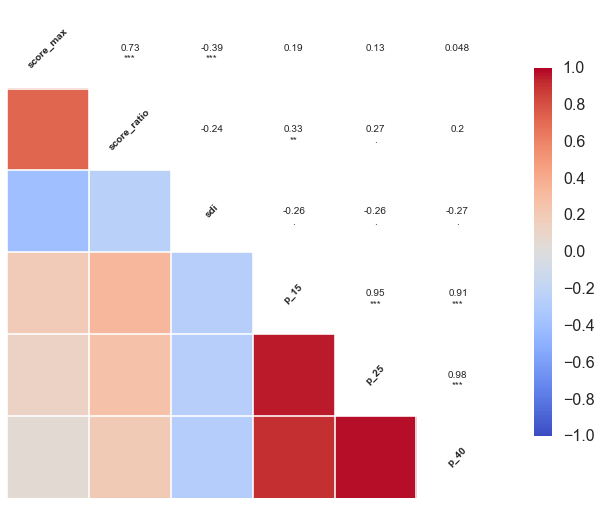

In [107]:
mpld3.disable_notebook()
sns.set_context('poster')
sns.corrplot(mv_summaries[['score_max', 'score_ratio', 'sdi', 'p_15', 'p_25', 'p_40']])

(-0.38548343105533756, 2.0969380835010936e-05)

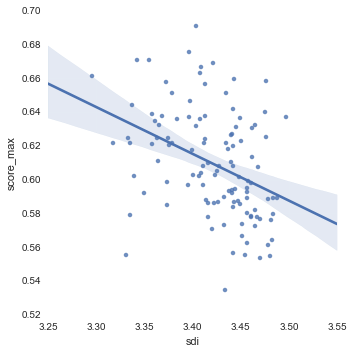

In [93]:
mpld3.enable_notebook()
max_sdi = sns.lmplot('sdi', 'score_max', mv_summaries)
stats.pearsonr(mv_summaries.sdi, mv_summaries.score_max)

In [100]:
deg_part

,region,d_15,d_25,d_40,p_15,p_25,p_40,score,fi_mean,fi_mean_abs,fi_var
0,1,15,25,34,0.238860,0.221370,0.249740,0.627909,0.046733,0.099526,0.020888
1,2,16,23,33,0.000000,0.035806,0.103320,0.656782,0.056460,0.114006,0.024892
2,3,21,33,52,0.645480,0.705680,0.722210,0.578341,0.016161,0.099448,0.014350
3,4,18,29,52,0.482890,0.618670,0.682000,0.595809,0.035881,0.094662,0.013289
4,5,19,33,55,0.601950,0.652370,0.693260,0.582186,-0.024355,0.090685,0.011883
5,6,15,30,55,0.505210,0.649800,0.694380,0.594696,-0.028046,0.095996,0.010843
6,7,14,31,51,0.414540,0.636740,0.682970,0.609744,0.021022,0.100313,0.017319
7,8,17,25,43,0.488770,0.590730,0.641050,0.613108,0.044988,0.100068,0.016287
8,9,19,30,50,0.655430,0.702610,0.727790,0.563050,0.005182,0.080544,0.008516
9,10,16,27,47,0.672380,0.709470,0.730980,0.546964,0.005179,0.071110,0.008044


In [94]:
stats.pearsonr(mv_summaries.sdi, mv_summaries.score_diff)

(-0.26671681660133795, 0.003959620022763532)